# Implementation Of Epsilon Greedy and Thompson Sampling Algorithms

## Importing Necessary Packages

In [1]:
from abc import ABC, abstractmethod
from logs import *
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from matplotlib.pyplot import plot
import os

In [2]:
logger = logging.getLogger("MAB Application")

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

ch.setFormatter(CustomFormatter())

logger.addHandler(ch)

## Initializing Bandit class

In [3]:
class Bandit(ABC):
    @abstractmethod
    def __init__(self, p):
        pass
        
    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def report(self):
        # store data in csv
        # log average reward (use f strings to make it informative)
        # log average regret (use f strings to make it informative)
        pass

## Implementation of Epsilon Greedy algorithm

In [4]:
class EpsilonGreedy(Bandit):
    def __init__(self, parameter, win_type: str):
        """
        Initialize the EpsilonGreedy bandit.

        Args:
            parameter (float): The true parameter of the bandit.
            win_type (str): Type of win, either "binary-win" for binary outcomes or "multy-win" for continuous outcomes.
        """
        self.parameter = parameter  # True parameter of the bandit
        self.parameter_estimate = 0  # Estimated parameter initialized to 0
        self.parameter_history = [self.parameter_estimate]  # History of parameter estimates
        self.win_type = win_type  # Type of win
        self.n = 0  # Number of pulls

    def __repr__(self):
        """
        Return a string representation of the bandit.
        """
        return f'Bandit with {self.parameter} Win Rate'

    def pull(self):
        """
        Simulate a single pull of the bandit.

        Returns:
            bool or float: The outcome of the pull.
        """
        if self.win_type == "binary-win":
            # For binary-win, return True with probability equal to the parameter
            return np.random.random() < self.parameter
        
        elif self.win_type == "multy-win":
            # For multy-win, return a sample from a normal distribution with mean equal to the parameter
            return np.random.randn() + self.parameter
        

    def update(self, x):
        """
        Update the parameter estimate based on the outcome of a pull.

        Args:
            x (bool or float): The outcome of the pull.
        """
        self.n += 1  # Increment the number of pulls
        if self.win_type == "binary-win":
            # Update the parameter estimate using incremental averaging
            self.parameter_estimate = ((self.n - 1)*self.parameter_estimate + x) / self.n

        elif self.win_type == "multy-win":
            # Update the parameter estimate using a weighted average
            self.parameter_estimate = (1 - 1.0/self.n)*self.parameter_estimate + 1.0/self.n*x
        
        self.parameter_history.append(self.parameter_estimate)  # Record the parameter estimate in history
        
    def experiment(self):
        """
        Perform an experiment with the bandit.
        """
        pass  # Placeholder for conducting an experiment

    def report(self):
        """
        Generate a report on the bandit's performance.
        """
        pass  # Placeholder for reporting results


## Implementation of Thompson Sampling algorithm

In [5]:
class ThompsonSampling(Bandit):
    def __init__(self, parameter, win_type: str):
        """
        Initialize the Thompson Sampling bandit.

        Args:
            parameter (float): The true parameter of the bandit.
            win_type (str): Type of win, either "binary-win" for binary outcomes or "multy-win" for continuous outcomes.
        """
        self.win_type = win_type  # Type of win
        self.parameter = parameter  # True parameter of the bandit
        self.parameter_estimate = 0  # Estimated parameter initialized to 0
        self.lambda_ = 1  # The precision parameter
        self.tau = 1  # Precision parameter for the prior distribution
        self.n = 0  # Number of pulls
        self.sum_x = 0  # Sum of observed rewards
        self.a = 0  # Alpha parameter for binary-win
        self.b = 0  # Beta parameter for binary-win
        self.parameter_history = [self.parameter_estimate]  # History of parameter estimates

    def __repr__(self):
        """
        Return a string representation of the bandit.
        """
        return f'Bandit with {self.parameter} Win Rate'

    def pull(self):
        """
        Simulate a single pull of the bandit.

        Returns:
            bool or float: The outcome of the pull.
        """
        if self.win_type == 'binary-win':
            # For binary-win, return True with probability equal to the parameter
            return np.random.random() < self.parameter
        
        elif self.win_type == 'multy-win':
            # For multy-win, return a sample from a normal distribution with mean equal to the parameter
            return np.random.randn() / np.sqrt(self.tau) + self.parameter
            
    def sample(self):
        """
        Sample from the posterior distribution.

        Returns:
            float: Sampled parameter value.
        """
        if self.win_type == 'binary-win':
            # Sample from the beta distribution
            return np.random.beta(self.a, self.b)
    
        elif self.win_type == 'multy-win':
            # Sample from the normal distribution with updated precision
            return np.random.randn() / np.sqrt(self.lambda_) + self.parameter_estimate

    def update(self, x):
        """
        Update the bandit based on the outcome of a pull.

        Args:
            x (bool or float): The outcome of the pull.
        """
        if self.win_type == 'binary-win':
            # Update the alpha and beta parameters of the beta distribution
            self.a += x
            self.b += 1 - x 
          
        elif self.win_type == 'multy-win':
            # Update the precision and estimated parameter for multy-win
            self.lambda_ += self.tau
            self.sum_x += x
            self.parameter_estimate = (self.tau * self.sum_x) / self.lambda_
            
        self.n += 1  # Increment the number of pulls
        self.parameter_history.append(self.parameter_estimate)  # Record the parameter estimate in history

    def experiment(self):
        """
        Perform an experiment with the bandit.
        """
        pass  # Placeholder for conducting an experiment

    def report(self):
        """
        Generate a report on the bandit's performance.
        """
        pass  # Placeholder for reporting results

## Implementation of Experiment class of Epsilon Greedy and Thompson Sampling algorithms.

In [6]:
class Experiment():
    def __init__(self, num_trials: int, bandit_param: list, win_type: str):
        """
        Initialize the Experiment class.

        Args:
            num_trials (int): Number of trials for the experiment.
            bandit_param (list): List of parameters for bandits.
            win_type (str): Type of win, either "binary-win" for binary outcomes or "multy-win" for continuous outcomes.
        """
        self.num_trials = num_trials  # Number of trials for the experiment
        self.bandit_param = bandit_param  # List of parameters for bandits
        self.win_type = win_type  # Type of win

    def experiment_for_greedy(self):
        """
        Perform an experiment using Epsilon-Greedy bandits.

        Returns:
            tuple: Tuple containing bandit names, bandits, rewards, number of times explored, number of times exploited, and number of times optimal.
        """
        bandits = [EpsilonGreedy(param, self.win_type) for param in self.bandit_param]  # Initialize EpsilonGreedy bandits
        rewards = np.zeros(self.num_trials)  # Array to store rewards
        num_times_explored = 0  # Counter for number of times explored
        num_times_exploited = 0  # Counter for number of times exploited
        num_optimal = 0  # Counter for number of times optimal
        bandit_name = []  # List to store bandit names

        optimal_j = np.argmax([b.parameter for b in bandits])  # Index of the optimal bandit
        for i in range(1, self.num_trials + 1):
            EPS = 1 / i  # Decay epsilon value

            if np.random.random() < EPS:
                num_times_explored += 1
                j = np.random.randint(len(bandits))  # Explore randomly

            else:
                num_times_exploited += 1
                j = np.argmax([b.parameter_estimate for b in bandits])  # Exploit best bandit

            if j == optimal_j:
                num_optimal += 1

            x = bandits[j].pull()  # Pull the arm of the selected bandit
            rewards[i - 1] = x  # Record the reward
            bandits[j].update(x)  # Update the bandit
            bandit_name.append(bandits[j])  # Record the bandit name

        return bandit_name, bandits, rewards, num_times_explored, num_times_exploited, num_optimal

    def experiment_for_thompson(self):
        """
        Perform an experiment using Thompson Sampling bandits.

        Returns:
            tuple: Tuple containing bandit names, bandits, rewards, number of times explored, number of times exploited, and number of times optimal.
        """
        bandits = [ThompsonSampling(param, self.win_type) for param in self.bandit_param]  # Initialize ThompsonSampling bandits
        rewards = np.zeros(self.num_trials)  # Array to store rewards
        num_times_explored = 0  # Counter for number of times explored
        num_times_exploited = 0  # Counter for number of times exploited
        num_optimal = 0  # Counter for number of times optimal
        bandit_name = []  # List to store bandit names

        optimal_j = np.argmax([b.parameter for b in bandits])  # Index of the optimal bandit
        for i in range(1, self.num_trials + 1):
            j = np.argmax([b.sample() for b in bandits])  # Select bandit with highest sampled value
            if j == optimal_j:
                num_optimal += 1

            x = bandits[j].pull()  # Pull the arm of the selected bandit
            rewards[i - 1] = x  # Record the reward
            bandits[j].update(x)  # Update the bandit
            bandit_name.append(bandits[j])  # Record the bandit name

        return bandit_name, bandits, rewards, num_times_explored, num_times_exploited, num_optimal

## Implementation of Report class which will create vizualizations and print important measures for the algorithms.   

In [7]:
class Report():
    def __init__(self, num_trials: int, bandit_param: list, win_type: str, algo_type: str):
        """
        Initialize the Report class.

        Args:
            num_trials (int): Number of trials for the experiment.
            bandit_param (list): List of parameters for bandits.
            win_type (str): Type of win, either "binary-win" for binary outcomes or "multy-win" for continuous outcomes.
            algo_type (str): Type of algorithm, either "Epsilon Greedy" or "Thompson Sampling".
        """
        self.num_trials = num_trials  # Number of trials for the experiment
        self.bandit_param = bandit_param  # List of parameters for bandits
        self.win_type = win_type  # Type of win
        self.algo_type = algo_type  # Type of algorithm

        # Initialize an Experiment instance
        self.experiment = Experiment(self.num_trials, self.bandit_param, self.win_type)

        # Perform the experiment based on the chosen algorithm type
        if self.algo_type == "Epsilon Greedy":
            self.bandit_name, self.bandits, self.rewards, self.num_times_explored, self.num_times_exploited, self.num_optimal = self.experiment.experiment_for_greedy()
        elif self.algo_type == "Thompson Sampling":
            self.bandit_name, self.bandits, self.rewards, self.num_times_explored, self.num_times_exploited, self.num_optimal = self.experiment.experiment_for_thompson()

    def plot1(self):
        """
        Plot the learning process of the algorithm.
        """
        for b in self.bandits:
            plt.plot(b.parameter_history, label=f'Bandit {b.parameter}')

        plt.xlabel('Number of Trials')
        plt.ylabel('Parameter Estimate')
        plt.yscale('symlog')
        plt.xscale('symlog')
        plt.title(f'Learning Process of the {self.algo_type} Algorithm')
        plt.legend()
        plt.show()

    def plot2(self):
        """
        Plot the convergence of the algorithm's win rate.
        """
        cumulative_rewards = np.cumsum(self.rewards)
        win_rates = cumulative_rewards / (np.arange(self.num_trials) + 1)
        plt.plot(win_rates, label="Win Rate")
        plt.plot(np.ones(self.num_trials) * np.max(self.bandit_param), label='Optimal Win Rate')
        plt.legend()
        plt.title(f"Win Rate Convergence of the {self.algo_type} Algorithm")
        plt.xlabel("Number of Trials")
        plt.ylabel("Average Reward")
        plt.show()

    def reward_file_store(self):
        """
        Store bandit names and rewards in a CSV file.
        """
        rewards_storage = "bandit_rewards.csv"

        # Open the CSV file in append mode
        with open(rewards_storage, 'a', newline='') as file:
            writer = csv.writer(file)

            # If this is the first write, write the header row
            if file.tell() == 0:
                writer.writerow(['bandit_name', 'reward', 'algorithm'])

            # Write each bandit name and reward as a row in the CSV file
            for bandit_name, reward in zip(self.bandit_name, self.rewards):
                writer.writerow([bandit_name, float(reward), self.algo_type])

        return "Rewards are stored in csv"

    def removing_reward_file(self):
        """
        Remove the reward CSV file if it exists.
        """
        rewards_storage = "bandit_rewards.csv"

        # Check if the file exists
        if os.path.exists(rewards_storage):
            # If it exists, delete the file
            os.remove(rewards_storage)
            return "Existing rewards file deleted"
        else:
            return "No existing rewards file found"

    def report(self):
        """
        Print the cumulative reward for the algorithm.
        """
        cumulative_reward = sum(self.rewards)
        optimal_reward = self.num_trials * max(self.bandit_param)
        cumulative_regret = optimal_reward - cumulative_reward
        
        print(f"The cumulative reward of {self.algo_type} : {round(cumulative_reward, 2)}")
        print(f"The cumulative regret of {self.algo_type} : {round(cumulative_regret, 2)}")

In [8]:
def comparison(algo_report1, algo_report2):
    name_algo1 = algo_report1.algo_type
    name_algo2 = algo_report2.algo_type
    reward_algo1 = algo_report1.rewards
    reward_algo2 = algo_report2.rewards
    
    num_optimal_algo1 = algo_report1.num_optimal
    num_optimal_algo2 = algo_report2.num_optimal

    # Create box plot
    plt.figure(figsize=(10, 6))
    plt.boxplot([reward_algo1, reward_algo2])
    plt.xlabel('Algorithm')
    plt.ylabel('Rewards')
    plt.title('Comparison of Rewards by Algorithm')
    plt.xticks([1, 2], [name_algo1, name_algo2])
    plt.grid(True)
    plt.show()
    

    names = [name_algo1, name_algo2]
    optimals = [num_optimal_algo1, num_optimal_algo2]
    
    fig, ax = plt.subplots()
    ax.bar(names, optimals)
    plt.xlabel('Algorithm')
    plt.ylabel('Number of Optimal Solutions')
    plt.title('Comparison of Optimal Solutions by Algorithm')
    plt.show()
    
    

## Testing the performance of the algorithms

## Epsilon Greedy Report result

In [9]:
np.random.seed(1)
Bandit_Reward = [1,2,3,4] 
NumberOfTrials =  20000
binary_win = 'binary-win'
multy_win = 'multy-win'

epsilon = "Epsilon Greedy"
thompson = "Thompson Sampling"

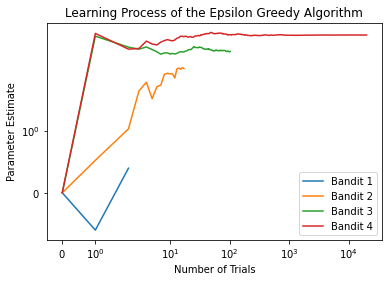

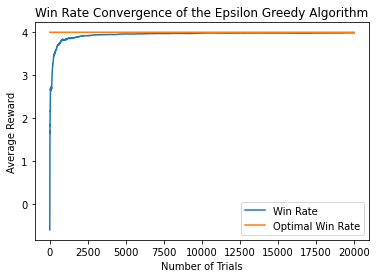

The cumulative reward of Epsilon Greedy : 79735.95
The cumulative regret of Epsilon Greedy : 264.05


In [10]:
report_for_greedy = Report(NumberOfTrials, Bandit_Reward, multy_win, epsilon)
report_for_greedy.plot1()
report_for_greedy.plot2()
report_for_greedy.report()

According to the both visualization, the Bandit 4 is considered better choice because after performing around 200 experiments, the Greedy algorithm starts choosing only Bandit 4 which after 2000 trials converges to the optimal mean by updating the estimated parameter.

## Thompson Sampling Report Result

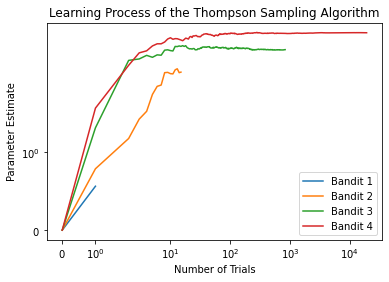

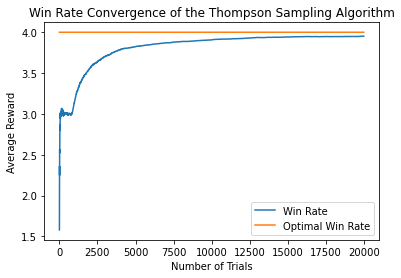

The cumulative reward of Thompson Sampling : 79029.14
The cumulative regret of Thompson Sampling : 970.86


In [11]:
report_for_thomson = Report(NumberOfTrials, Bandit_Reward, multy_win, thompson)
report_for_thomson.plot1()
report_for_thomson.plot2()
report_for_thomson.report()

According to the both visualization, the Bandit 4 is considered better choice because after performing around 800 experiments, the Thompson Sampling algorithm starts choosing only Bandit 4 which after 2000 trials converges to the optimal mean by updating the estimated parameter.

It is important to mention that in this example, the Greedy algorithm performs better than Thompson Sampling because in the Greedy algorithm, the Bandit 4 converges to the actual mean quicker. Besides, the cumulative regret is considerably higher for Thompson Sampling.

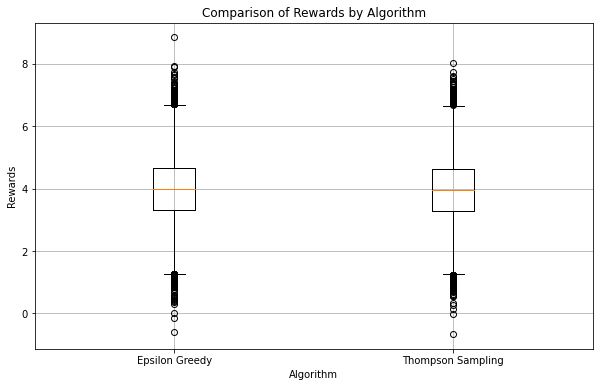

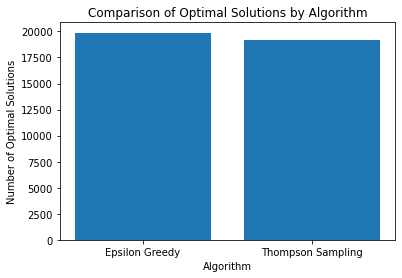

In [12]:
comparison(report_for_greedy, report_for_thomson)

* Box Plot Interpretation
    * For both of the algorithms the median rewards are almost 4. If we look closely, we can find that the median of Greedy algorithm is a bit closer to 4 than Thompson's mean. Both of the algorithms got a lot of outliers and almost equal variances.
* Bar Plot Interpretation
    * The plot shows that the Greedy algorithm generated more optimal values than Thompson Samling. However, both of them performed well and have optimal solutions close to number of trials.

In [13]:
report_for_thomson.removing_reward_file()

'No existing rewards file found'

In [14]:
report_for_greedy.reward_file_store()
report_for_thomson.reward_file_store()

'Rewards are stored in csv'

In [15]:

if __name__=='__main__':

    logger.debug("debug message")
    logger.info("info message")
    logger.warning("warning message")
    logger.error("error message")
    logger.critical("critical message")


2024-04-13 21:05:17,563 - MAB Application - WARNING - warning message (line: 5)
2024-04-13 21:05:17,571 - MAB Application - ERROR - error message (line: 6)
2024-04-13 21:05:17,572 - MAB Application - CRITICAL - critical message (line: 7)
